In [109]:
import os
import numpy as np
from PIL import Image
import PIL.ImageOps    
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import image_registration
from astropy.nddata import Cutout2D
from astropy import units as u
import matplotlib.image as mpimg

from __future__ import print_function
#import cv2
import numpy as np

from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry

from astropy.stats import sigma_clipped_stats

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

 
import pandas as pd
import pandasql as ps
plt.style.use(astropy_mpl_style)

from regions.core import PixCoord
from regions.shapes.circle import CirclePixelRegion
import scipy.misc
import time

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


In [2]:
def makeFits(inName,imageExtension='.jpg'):
    image = Image.open(inName)
    xsize, ysize = image.size
    print("Image size: {} x {}".format(xsize, ysize))
    # plt.imshow(image)

    r, g, b = image.split()
    r_data = np.array(r.getdata()) # data is now an array of length ysize*xsize
    g_data = np.array(g.getdata())
    b_data = np.array(b.getdata())
    print(r_data.shape)

    r_data = r_data.reshape(ysize, xsize)[::-1]
    g_data = g_data.reshape(ysize, xsize)[::-1]
    b_data = b_data.reshape(ysize, xsize)[::-1]

    inName = inName.replace(imageExtension,'')
    print(inName)
    try:
        os.remove(inName+"red.fits")
        os.remove(inName+"green.fits")
        os.remove(inName+"blue.fits")
    except:
        print("Can't remove as the file doesn't exist")

    red = fits.PrimaryHDU(r_data)
    hdur = fits.HDUList([red])
    hdur.writeto(inName+'red.fits')
    
    green = fits.PrimaryHDU(g_data)
    hdug = fits.HDUList([green])
    hdug.writeto(inName+'green.fits')

    blue = fits.PrimaryHDU(b_data)
    hdub = fits.HDUList([blue])
    hdub.writeto(inName+'blue.fits')

In [63]:
def saveImData(imData,name):
    im = fits.PrimaryHDU(imData)
    hdub = fits.HDUList([im])
    hdub.writeto(name)

In [101]:
def daoStarFinder(imagename,FWHM=50,thresh=3.,graph='yes',imData='none'):
    """
    Locates and measures the brightness of all objects in the image as well as the sky background
    and other image data.

    :param imagenumber: Position of image in directory
    :return: Table of object data, date of observation, image data for backround calculation
    """
    #print(Image[imagenumber])
    if imData == 'none':
        hdu_list = fits.open(imagename) # open image header
        imagedata = (hdu_list[0].data) 
    else:
        imagedata = imData
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
#     imagedata[imagedata < 0.75*mean] = 0
#     mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
#     Median.append(median)
#     STD.append(std)
    print(mean,median,std)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=thresh*std) # iraf star finder 
    Sources = daofind(imagedata - median)
    #Date = (hdu_list[0].header['MJD'])
    output = {}
    output[0] = Sources
    output[1] = [mean,median,std]
#     output[1] = Date
#     output[2] = imagedata
    if graph == 'yes':
        fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10, 10))
        positions = (output[0]['xcentroid'], output[0]['ycentroid'])
        apertures = CircularAperture(positions, r=10.)
        norm = ImageNormalize(stretch=SqrtStretch())
        ax1.imshow(imagedata, cmap='Greys', origin='lower')#norm=norm)
        apertures.plot(color='black', lw=1.5, alpha=0.5)
        #plt.savefig('fits.png',dpi=100)
        ax2.imshow(imagedata, cmap='Greys', origin='lower')
        plt.show()
    
    
    
#     os.chdir(bindingsdirectory)
#     astroprov.provcall([imagenumber],[output[0],output[1],output[2]],"daoStarFinder_PythonCode2Images_SQ_tmpl.provn","daoStarFinder")
#     os.chdir(imagedirectory)
    return output




In [122]:
def assessQuality(output,sqlQuery,refPandasNew):
    pandasTable = Table.to_pandas(output[0])
    newdf = ps.sqldf(sqlQuery,locals())
    Nrecovered = len(newdf)
    Ntarget = len(refPandasNew)
    Ntot = len(pandasTable)
    if len(newdf) != 0:
        completeness = float(Nrecovered)/float(Ntarget)
        accuracy = float(Nrecovered)/float(Ntot)
    else:
        print('no objects found')
        completeness = 0
        accuracy = 0
    total = completeness + accuracy
    return [completeness,accuracy,total,Nrecovered,Ntarget,Ntot]

In [5]:
def ds9File2Lists(fileName):
    with open(fileName,'r') as f:
        data = f.readlines()

    ycoord = []
    xcoord = []
    radius = []
    starLocations = []
    for x in data[:-1]:
        locator1 = '('
        locator2 = ','
        locator3 = ')'
        loc1 = x.index(locator1) +1
        #print(x)
        loc2 = x[loc1:].index(locator2) + loc1 +1
        loc3 = x[loc2:].index(locator2) + loc2
        loc4 = x.index(locator3)
        xcoord.append(float(x[loc1:loc2-1]))
        ycoord.append(float(x[loc2:loc3]))
        radius.append(float(x[loc3+1:loc4]))
    return [xcoord,ycoord,radius]

In [6]:
def matchTables(table1,table2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.xcentroid < pandasTable2.xUpper
    AND pandasTable1.xcentroid > pandasTable2.xLower
    AND pandasTable1.ycentroid < pandasTable2.yUpper
    AND pandasTable1.ycentroid > pandasTable2.yLower
    '''
    pandasTable1 = Table.to_pandas(table1)
    
    xcoord = table2['xcentroid']
    ycoord = table2['ycentroid']
    flux = table2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'index':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [7]:
def matchTables2(table1,table2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.xcentroid < pandasTable2.xUpper2
    AND pandasTable1.xcentroid > pandasTable2.xLower2
    AND pandasTable1.ycentroid < pandasTable2.yUpper2
    AND pandasTable1.ycentroid > pandasTable2.yLower2
    '''
    pandasTable1 = Table.to_pandas(table1)
    
    xcoord = table2['xcentroid']
    ycoord = table2['ycentroid']
    flux = table2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'index2':range(len(xcoord)),'xcoord2':xcoord,'ycoord2':ycoord,'xUpper2':xUpper,'xLower2':xLower,
              'yUpper2':yUpper,'yLower2':yLower,'fluxMatch2':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [8]:
def findAndRefine(image,fwhm=20,thr=3):
    imShort = image[:image.index('.jpg')]
    
    imagedata = Image.open(image)
    inverted_image = PIL.ImageOps.invert(imagedata)
    inverted_image.save(imShort+'Inverted.jpg')
    makeFits(imShort+'Inverted.jpg')
    imGreen,imBlue,imRed = imShort+'Invertedgreen.fits',imShort+'Invertedblue.fits',imShort+'Invertedred.fits'
    
    outputAlignBlue = daoStarFinder(imBlue,FWHM=fwhm,thresh=thr)
    outputAlignRed = daoStarFinder(imRed,FWHM=fwhm,thresh=thr)
    outputAlignGreen = daoStarFinder(imGreen,FWHM=fwhm,thresh=thr)
    
    matchedObjects = matchTables(outputAlignBlue[0],outputAlignGreen[0])
    matchedObjects2 = matchTables2(Table.from_pandas(matchedObjects),outputAlignRed[0])
    
    matchedObjects = matchedObjects2
    
#     fluxRatio = [x/y for x,y in zip(matchedObjects['flux'].tolist(),matchedObjects['fluxMatch'].tolist())]
    
#     dropRows = []
#     medianFlux = np.median(fluxRatio)
#     stdFlux = np.std(fluxRatio)
#     print(len(fluxRatio))

#     for i,x in enumerate(fluxRatio):
#         if x > medianFlux + (stdFlux):
#             dropRows.append(i)
#         if x < medianFlux - (stdFlux):
#             dropRows.append(i)

    matchedRefined = matchedObjects #.drop(dropRows)
#     matchedRefined.sort_values(by=['flux'])
#     matchedRefined = matchedRefined[0:25]
    
    hdu_list = fits.open(imGreen)
    imagedata = hdu_list[0].data
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10, 10))
    positions = (matchedRefined['xcentroid'].tolist(), matchedRefined['ycentroid'].tolist())
    apertures = CircularAperture(positions, r=10.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax1.imshow(imagedata, cmap='Greys', origin='lower')#norm=norm)
    apertures.plot(color='black', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    ax2.imshow(imagedata, cmap='Greys', origin='lower')
    plt.show()
    
    return matchedRefined

In [9]:
def getImageData(imageName,extension):
    hdu = fits.open(imageName)
    imageData = hdu[extension].data
    return imageData

In [10]:
def alignImages(hdulist):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
    alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    for image in range(1,len(hdulist)):
        im1 = hdulist[image]
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
        alignedHDU.append(im1_aligned_to_im2)

    return alignedHDU


In [175]:
def alignImagesAlt(hdulist,hdulistOriginals):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
    alignedHDU = [hdulistOriginals[0]]
    im2 = hdulist[0]
    for image in range(1,len(hdulist)):
        im1 = hdulist[image]
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(hdulistOriginals[1],int(yoff),1),int(xoff),0)
        alignedHDU.append(im1_aligned_to_im2)

    return alignedHDU


In [11]:
def plotMolesAndMask(image,moleLocFile):
    imdata = getImageData(image,0)
    moleLocs = ds9File2Lists(moleLocFile)
    imageShape = imdata.shape
    zeros = np.zeros(imdata.shape)
    alignlocs = moleLocs
    
    mask = []
    maskData = []
    for mole in range(len(alignlocs[0])):
        centre = PixCoord(alignlocs[0][mole],alignlocs[1][mole])
        reg = CirclePixelRegion(centre,alignlocs[2][mole])
        mask.append(reg.to_mask())
        maskData.append(mask[mole].cutout(imdata)*mask[mole].data)
        #print(mole,-(int(alignlocs[1][mole])-maskSize)+int(alignlocs[1][mole])+maskSize)
        maskDataShape = maskData[mole].shape
        if maskDataShape[0] % 2 != 0:
            maskData[mole] = maskData[mole][0:-1,0:]
        if maskDataShape[1] % 2 != 0:
            maskData[mole] = maskData[mole][0:,0:-1]
            #print('sdkfhb')
        newMaskShape = maskData[mole].shape
        xsize = newMaskShape[0]/2
        ysize = newMaskShape[1]/2
        print(maskData[mole].shape)
        zeros[int(alignlocs[1][mole])-xsize:int(alignlocs[1][mole])+xsize,int(alignlocs[0][mole])-ysize:int(alignlocs[0][mole])+ysize] = maskData[mole]
    
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,10))
    ax1.imshow(imdata)
    for x in range(len(mask)):
        ax1.add_artist(mask[x].bbox.as_artist(facecolor='none', edgecolor='white'))
    ax2.imshow(zeros)
    plt.show()
    
    return {'mask':mask,'maskData':maskData,'maskedImage':zeros,'moleLocs':moleLocs}

In [12]:
def plotMolesAndFakeMask(image,moleLocFile,gauss2D):
    imdata = getImageData(image,0)
    moleLocs = ds9File2Lists(moleLocFile)
    imageShape = imdata.shape
    zeros = np.zeros(imdata.shape)
    alignlocs = moleLocs
    
    mask = []
    maskData = []
    for mole in range(len(alignlocs[0])):
        centre = PixCoord(alignlocs[0][mole],alignlocs[1][mole])
        reg = CirclePixelRegion(centre,24.5)
        mask.append(reg.to_mask())
        print(mask[mole].shape)
        maskData.append(mask[mole].cutout(imdata)*gauss2D)
        #print(mole,-(int(alignlocs[1][mole])-maskSize)+int(alignlocs[1][mole])+maskSize)
        maskDataShape = maskData[mole].shape
        if maskDataShape[0] % 2 != 0:
            maskData[mole] = maskData[mole][0:-1,0:]
        if maskDataShape[1] % 2 != 0:
            maskData[mole] = maskData[mole][0:,0:-1]
            #print('sdkfhb')
        newMaskShape = maskData[mole].shape
        xsize = newMaskShape[0]/2
        ysize = newMaskShape[1]/2
        print(maskData[mole].shape)
        zeros[int(alignlocs[1][mole])-xsize:int(alignlocs[1][mole])+xsize,int(alignlocs[0][mole])-ysize:int(alignlocs[0][mole])+ysize] = maskData[mole]
    
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,10))
    ax1.imshow(imdata)
    for x in range(len(mask)):
        ax1.add_artist(mask[x].bbox.as_artist(facecolor='none', edgecolor='white'))
    ax2.imshow(zeros)
    plt.show()
    
    return {'mask':mask,'maskData':maskData,'maskedImage':zeros,'moleLocs':moleLocs}

In [13]:
def plotMolesOnly(image,moleLocFile):
    imdata = getImageData(image,0)
    moleLocs = ds9File2Lists(moleLocFile)
    alignlocs = moleLocs
    mask = []
    #maskData = []
    for mole in range(len(alignlocs[0])):
        centre = PixCoord(alignlocs[0][mole],alignlocs[1][mole])
        reg = CirclePixelRegion(centre,alignlocs[2][mole])
        mask.append(reg.to_mask())
        #maskData.append(mask[mole].cutout(imdata)*mask[mole].data)
    
    fig, ax1 = plt.subplots(1,1,figsize=(10,10))
    ax1.imshow(imdata)
    for x in range(len(mask)):
        ax1.add_artist(mask[x].bbox.as_artist(facecolor='none', edgecolor='white'))
    #ax2.imshow(zeros)
    plt.show()

In [45]:
def backgroundSubtraction(imData):
    for x in range(len(imData)):
        meanVal = np.mean(imData[x])
        meanLimit = meanVal*0.75
        background = imData[x][imData[x]<meanLimit]
        backGroundVal = np.mean(background) 
        imData[x] = imData[x] - backGroundVal
        imData[imData < 0] = 0
    return imData

In [99]:
def makeAverageImage(redimage,blueimage,greenimage):
    moleImage = (redimage+blueimage+greenimage)/3
    return moleImage


In [100]:
redIm = getImageData('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',0)
blueIm = getImageData('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',0)
greenIm = getImageData('/home/mj1e16/moleGazer/Photos/F/29018Invertedgreen.fits',0)
avIm = makeAverageImage(redIm,blueIm,greenIm)
bsAvIm = backgroundSubtraction(avIm)

In [102]:
saveImData(bsAvIm,'/home/mj1e16/moleGazer/Photos/F/29018moleAv.fits')

In [50]:
redIm = getImageData('/home/mj1e16/moleGazer/Photos/F/79948Invertedred.fits',0)
blueIm = getImageData('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits',0)
greenIm = getImageData('/home/mj1e16/moleGazer/Photos/F/79948Invertedgreen.fits',0)

In [51]:
moleBrightIm = makeMoleBrightImage(redIm,blueIm,greenIm)
bsMoleIm = backgroundSubtraction(moleBrightIm) 

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


In [80]:
redblue = redIm*blueIm
greenSquared = greenIm
moleTestIm = np.true_divide(redblue,greenSquared)
meanImage = (redIm+greenIm+blueIm)/3
molebrightNew = moleTestIm

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [81]:
saveImData(molebrightNew,'/home/mj1e16/moleGazer/Photos/F/799moleBrightNormal3.fits')

In [82]:
meanImage = (redIm+greenIm+blueIm)/3
saveImData(meanImage,'/home/mj1e16/moleGazer/Photos/F/799Mean.fits')

In [83]:
testImageData = backgroundSubtraction(meanImage)

In [86]:
saveImData(testImageData,'/home/mj1e16/moleGazer/Photos/F/799MeanBS.fits')

In [84]:
sqlcode = '''
SELECT *
FROM pandasTable
JOIN refPandasNew
ON pandasTable.xcentroid < refPandasNew.xUpper
AND pandasTable.xcentroid > refPandasNew.xLower
AND pandasTable.ycentroid < refPandasNew.yUpper
AND pandasTable.ycentroid > refPandasNew.yLower
'''

In [85]:
with open('./molePositions.txt','r') as f:
    data = f.readlines()
    
ycoord = []
xcoord = []
starLocations = []
for x in data[:-1]:
    locator1 = '('
    locator2 = ','
    loc1 = x.index(locator1) +1
    #print(x)
    loc2 = x[loc1:].index(locator2) + loc1 +1
    loc3 = x[loc2:].index(locator2) + loc2
    xcoord.append(x[loc1:loc2-1])
    ycoord.append(x[loc2:loc3])
    #starLocations.append([float(xcoord),float(ycoord)])
tollerance = 5

xUpper = [float(x) + tollerance for x in xcoord]
xLower = [float(x) - tollerance for x in xcoord]
yUpper = [float(x) + tollerance for x in ycoord]
yLower = [float(x) - tollerance for x in ycoord]

refDict = {'index':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
          'yUpper':yUpper,'yLower':yLower}
refPandasNew = pd.DataFrame(data=refDict)

In [131]:
comp,acc,tot,settings = [],[],[],[]
Nrecovered,Ntarget,Ntot = [],[],[]
t0 = time.time()
FWHM = range(5,105,5)
thresh = range(3,10,1)

for fwhm in FWHM:
    ts = time.time()
    for thr in thresh:
        t1 = time.time()
        output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018moleAv.fits',FWHM=fwhm,thresh=thr,graph='no',imData=bsAvIm)
        t2 = time.time()
        quality = assessQuality(output,sqlcode,refPandasNew)
        t3 = time.time()
        print('dao Time',t2-t1)
        print('quality Time', t3-t2)
        comp.append(quality[0])
        acc.append(quality[1])
        tot.append(quality[2])
        settings.append([fwhm,thr])
        Nrecovered.append(quality[3])
        Ntarget.append(quality[4])
        Ntot.append(quality[5])
    print('tot time per cycle',t3-ts)
print('tot time',time.time() - t0)

with open('./outputTake2.py','2') as f:
    f.write('comp = '+str(comp)+'\nacc = '+str(acc)+'\ntot = '+str(tot)+'\nsettings = '+str(settings)+'\nNrecovered = '+str(Nrecovered)+'\nNtarget = '+str(Ntarget)+'\nNtot = '+str(Ntot))

/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 3.82383298874
quality Time 0.0159480571747
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 3.75888109207
quality Time 0.0153288841248
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 3.77884292603
quality Time 0.0158100128174
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 3.81344389915
quality Time 0.0157389640808
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 3.77238798141
quality Time 0.0148091316223
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 3.75038099289
quality Time 0.0142030715942
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 3.72432017326
quality Time 0.013790845871
tot time per cycle 26.5303499699
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 4.97210407257
quality Time 0.0145230293274
63.428018422074416 85.0 51.50695678340368
no objects found
dao Time 4.9435920715

ValueError: mode string must begin with one of 'r', 'w', 'a' or 'U', not '2'

In [132]:
with open('./outputTake2.py','w') as f:
    f.write('comp = '+str(comp)+'\nacc = '+str(acc)+'\ntot = '+str(tot)+'\nsettings = '+str(settings)+'\nNrecovered = '+str(Nrecovered)+'\nNtarget = '+str(Ntarget)+'\nNtot = '+str(Ntot))

In [128]:
comp = comp[:70]
acc = acc[:70]
tot = tot[:70]

In [130]:
compsave = comp
accsave = acc
totsave = tot

In [1]:
with open('./output.txt','w') as f:
    f.write('comp = '+str(comp)+'\nacc = '+str(acc)+'\ntot = '+str(tot)+'\nsettings = '+str(settings))

NameError: name 'comp' is not defined

In [106]:
fullwhm = [x[0] for x in settings]
threshold = [x[1] for x in settings]

In [136]:
fullwhm = range(5,105,5)
threshold = range(3,10,1)

In [140]:
accReformat = []
compReformat = []
totQualityReformat = []
for x in range(len(acc)/len(fullwhm)):
    accReformat.append(acc[x:x+len(fullwhm)])
    compReformat.append(comp[x:x+len(fullwhm)])
    totQualityReformat.append(tot[x:x+len(fullwhm)])

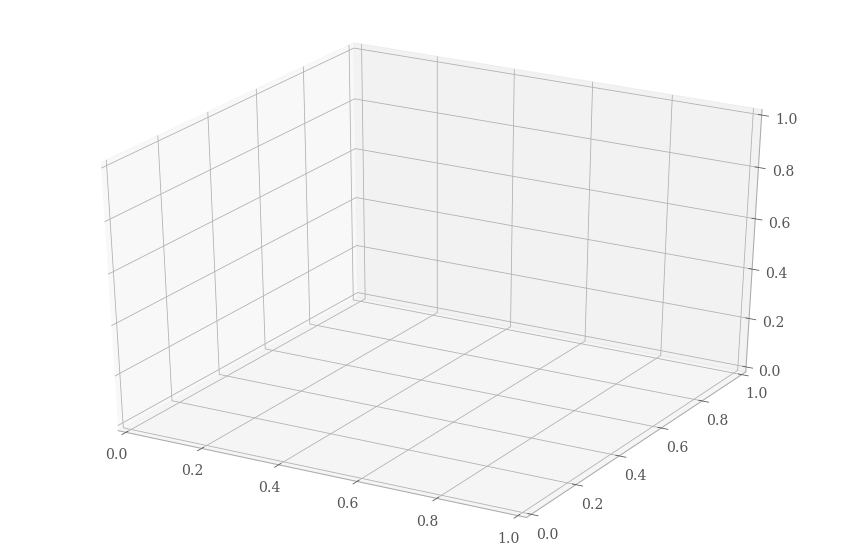

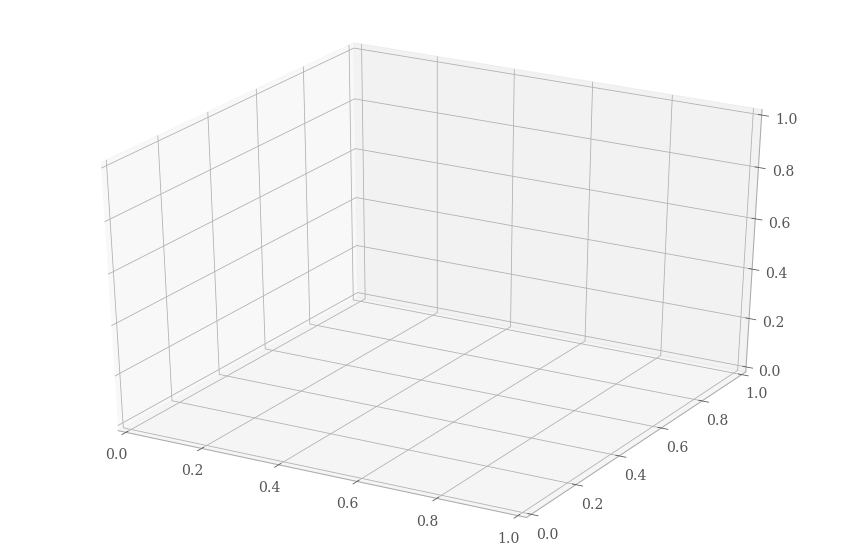

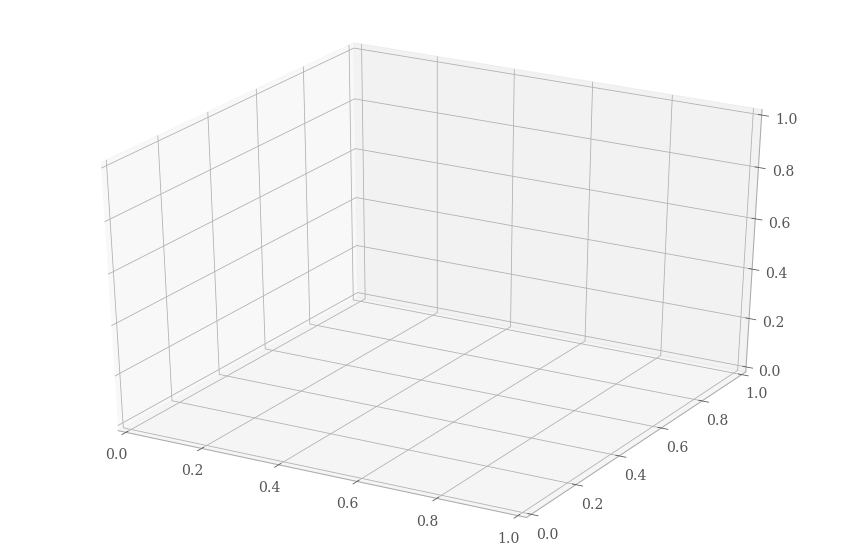

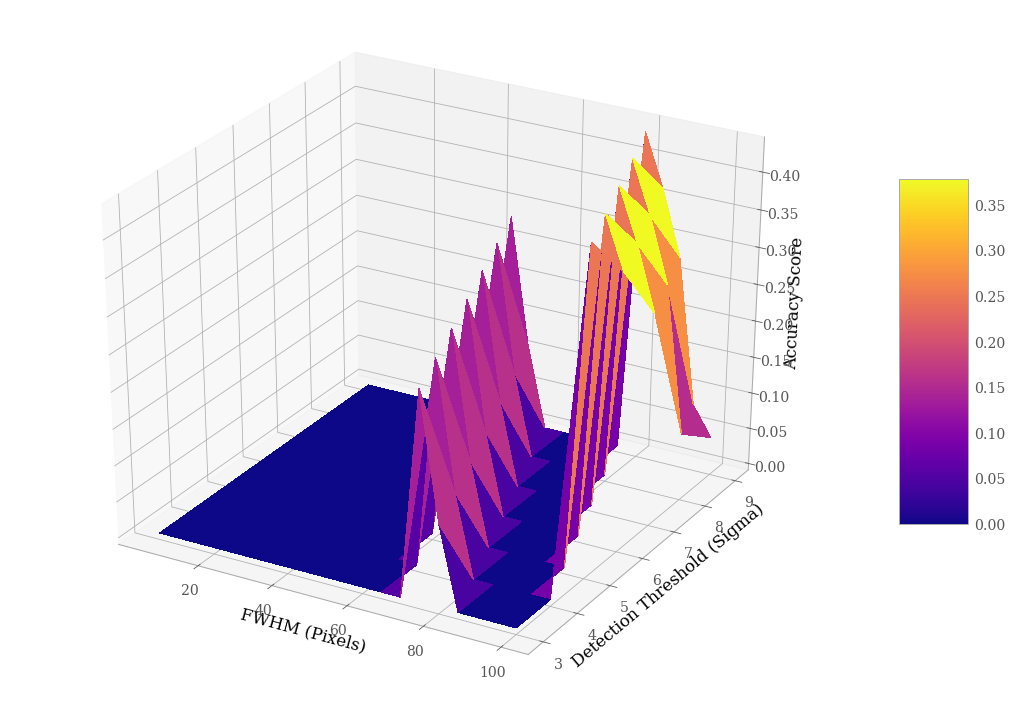

In [142]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=1)
#surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(fullwhm,threshold)
Z = np.array(accReformat)
surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.gca().invert_zaxis()
plt.xlabel('FWHM (Pixels)')
plt.ylabel('Detection Threshold (Sigma)')
ax.set_zlabel('Accuracy Score')
plt.tight_layout()
#plt.savefig('/home/mj1e16/thesisFigures/acc'+Filters[filt]+'.png')
plt.show()

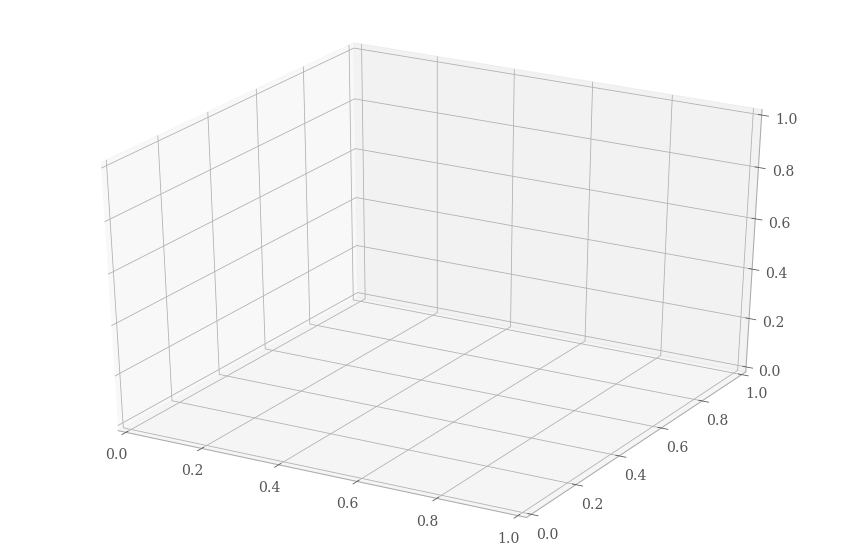

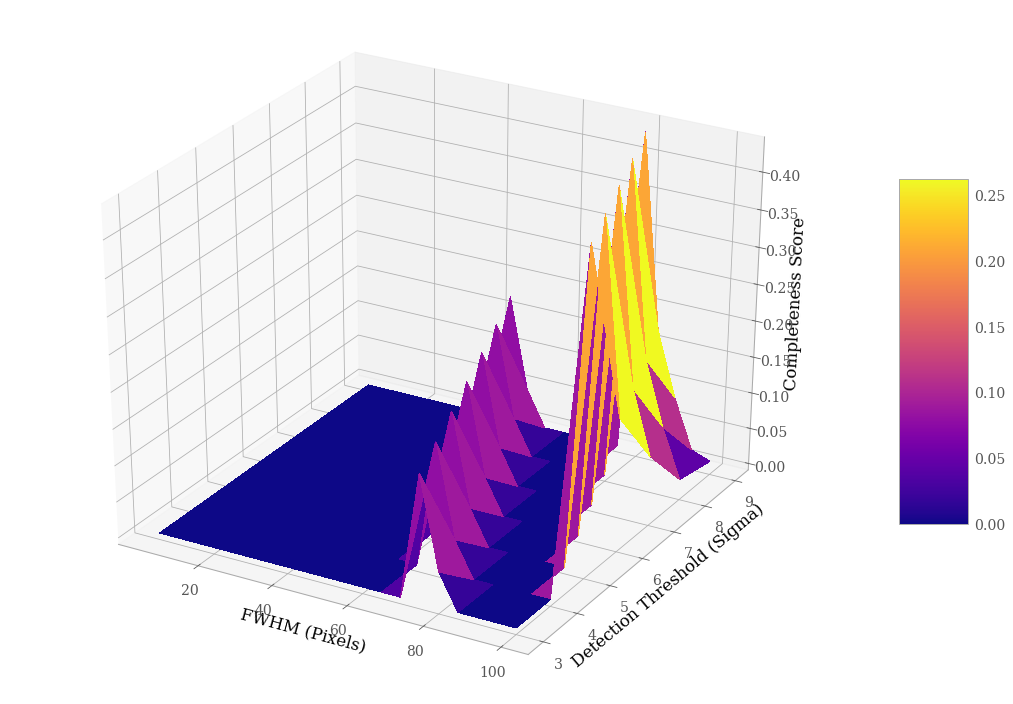

In [143]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=1)
#surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(fullwhm,threshold)
Z = np.array(compReformat)
surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.gca().invert_zaxis()
plt.xlabel('FWHM (Pixels)')
plt.ylabel('Detection Threshold (Sigma)')
ax.set_zlabel('Completeness Score')
plt.tight_layout()
#plt.savefig('/home/mj1e16/thesisFigures/acc'+Filters[filt]+'.png')
plt.show()

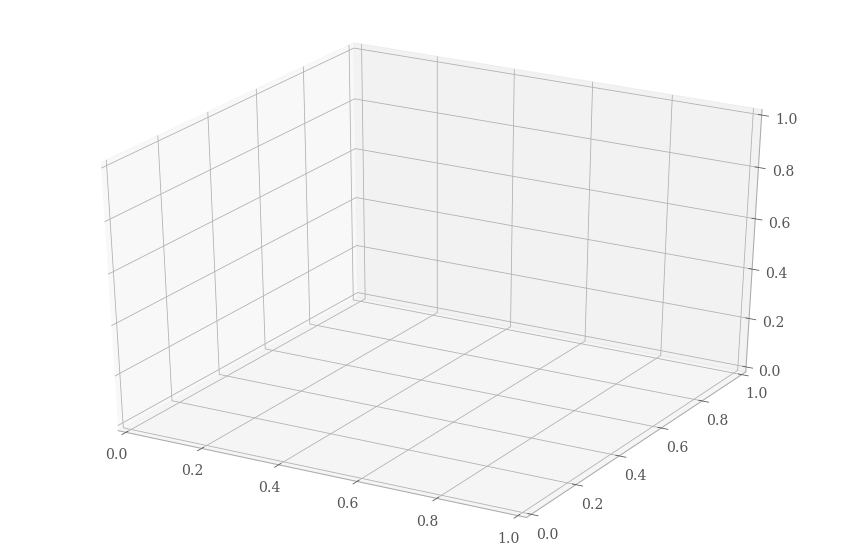

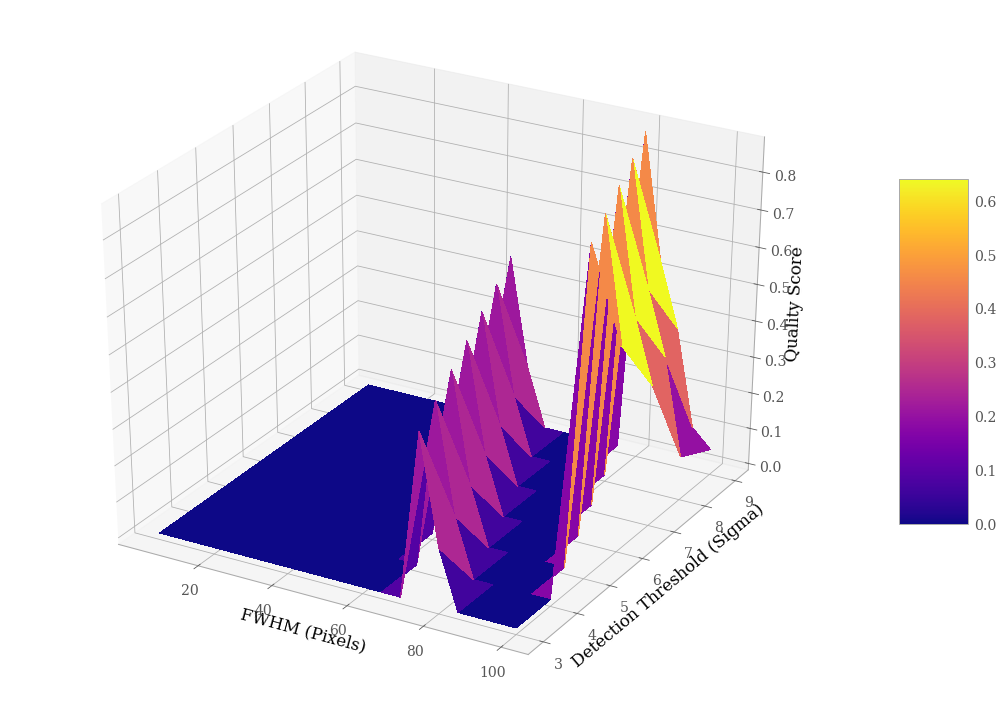

In [145]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=1)
#surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(fullwhm,threshold)
Z = np.array(totQualityReformat)
surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.gca().invert_zaxis()
plt.xlabel('FWHM (Pixels)')
plt.ylabel('Detection Threshold (Sigma)')
ax.set_zlabel('Quality Score')
plt.tight_layout()
#plt.savefig('/home/mj1e16/thesisFigures/acc'+Filters[filt]+'.png')
plt.show()

In [98]:
print(acc)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.005649717514124294, 0.006369426751592357, 0.010101010101010102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0125, 0.015384615384615385, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
with open('./output.txt','r') as f:
    f.write('comp = '+str(comp)+'\nacc = '+str(acc)+'\ntot = '+str(tot)+'\nsettings = '+str(settings))

In [146]:
import outputTake2

In [160]:
minimumAccuracy = max(outputTake2.Ntot)
Accuracy = [1 - float(x)/float(minimumAccuracy) for x in outputTake2.Ntot]

In [161]:
def reformatQuality(quality,fwhm):
    qualityReformat = []
    for x in range(len(quality)/len(fwhm)):
        qualityReformat.append(quality[x:x+len(fwhm)])

    return qualityReformat


In [162]:
accReformat = reformatQuality(Accuracy,fullwhm)

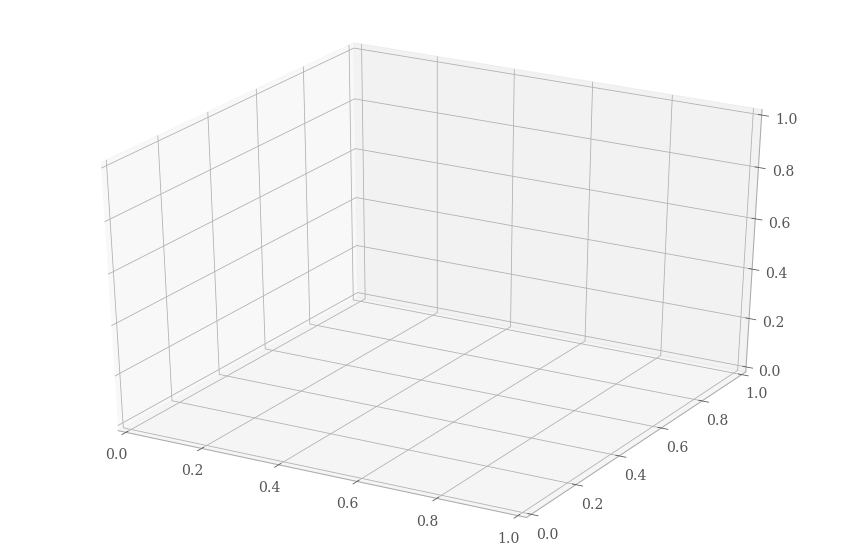

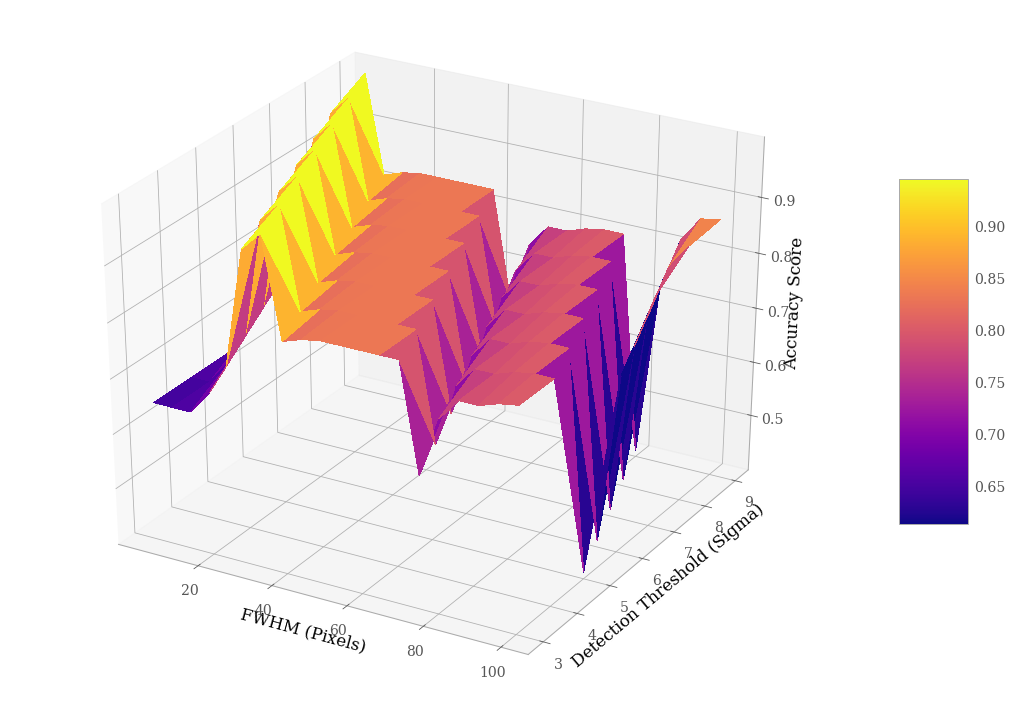

In [163]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=1)
#surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(fullwhm,threshold)
Z = np.array(accReformat)
surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.gca().invert_zaxis()
plt.xlabel('FWHM (Pixels)')
plt.ylabel('Detection Threshold (Sigma)')
ax.set_zlabel('Accuracy Score')
plt.tight_layout()
plt.savefig('/home/mj1e16/moleGazer/MoleGazer/accuracyDAO.png')
plt.show()

In [96]:
#comp,acc,tot,settings = [],[],[],[]

t0 = time.time()
FWHM = range(5,155,10)
thresh = range(3,10,1)

fwhm = 105
for thr in [7,8,9]:
    t1 = time.time()
    output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/799MeanBS.fits',FWHM=fwhm,thresh=thr,graph='no')
    t2 = time.time()
    quality = assessQuality(output,sqlcode,refPandasNew)
    t3 = time.time()
    print('dao Time',t2-t1)
    print('quality Time', t3-t2)
    comp.append(quality[0])
    acc.append(quality[1])
    tot.append(quality[2])
    settings.append([fwhm,thr])
print('tot time per cycle',t3-ts)
print('tot time',time.time() - t0)

# with open('./output.txt','r') as f:
# f.write('comp = '+str(comp)+'\nacc = '+str(acc)+'\ntot = '+str(tot)+'\nsettings = '+str(settings))

28.821280615056427 0.0 35.34788610222013


KeyboardInterrupt: 

In [ ]:
#comp,acc,tot,settings = [],[],[],[]

t0 = time.time()
FWHM = range(5,155,10)
thresh = range(3,10,1)

for fwhm in FWHM[-4:]:
    ts = time.time()
    for thr in thresh:
        t1 = time.time()
        output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/799MeanBS.fits',FWHM=fwhm,thresh=thr,graph='no')
        t2 = time.time()
        quality = assessQuality(output,sqlcode,refPandasNew)
        t3 = time.time()
        print('dao Time',t2-t1)
        print('quality Time', t3-t2)
        comp.append(quality[0])
        acc.append(quality[1])
        tot.append(quality[2])
        settings.append([fwhm,thr])
    print('tot time per cycle',t3-ts)
print('tot time',time.time() - t0)

with open('./output.txt','r') as f:
    f.write('comp = '+str(comp)+'\nacc = '+str(acc)+'\ntot = '+str(tot)+'\nsettings = '+str(settings))

In [264]:
comp,acc,tot,settings = [],[],[],[]

FWHM = range(5,105,5)
thresh = range(1,10)

for fwhm in FWHM:
    for thr in thresh:
        output = daoStarFinder('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',FWHM=fwhm,thresh=thr,graph='no')
        quality = assessQuality(output,sqlcode,refPandasNew)
        comp.append(quality[0])
        acc.append(quality[1])
        tot.append(quality[2])
        settings.append([fwhm,thr])

66.90609213343083 89.0 54.582023222885155


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/photutils/detection/findstars.py:771: RuntimeWarning: divide by zero encountered in double_scalars
  dx = (sgdgdx - (sddgdx - sdgdx*sumd)) / (hx * sdgdx2 / kernel_sigma**2)


66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
66.90609213343083 89.0 54.582023222885155
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.582023222885155
no objects found
66.90609213343083 89.0 54.58202

KeyboardInterrupt: 

In [167]:
x, y = np.meshgrid(np.linspace(1,50,50), np.linspace(1,50,50))
d = np.sqrt(x*x+y*y)
sigma, mu = 5., 0.0
g = 1000 * np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)


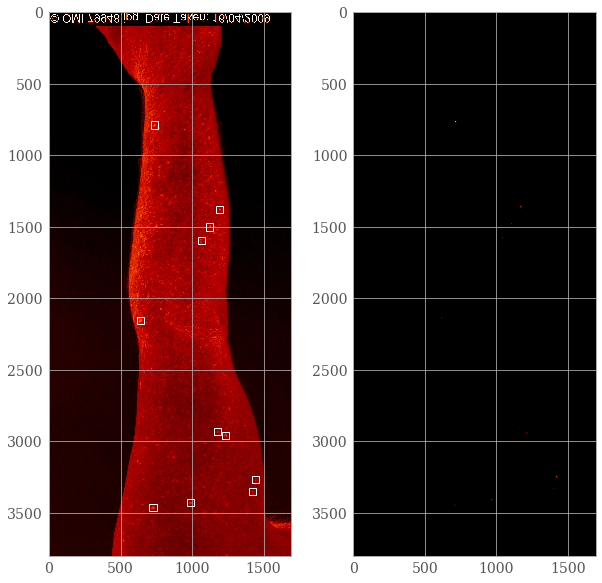

In [168]:
maskingDataFake = plotMolesAndFakeMask('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits','./79948blueMolePositions.txt',g)

(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)
(50, 50)


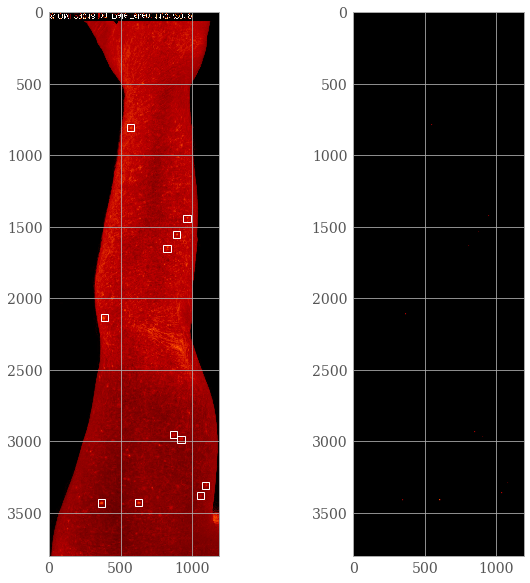

In [169]:
maskingDataRefFake = plotMolesAndFakeMask('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits','./29018blueMolePositions.txt',g)

In [170]:
print(hdu_list[0].shape)
print(hdu_list[1].shape)

NameError: name 'hdu_list' is not defined

(3800, 1190)


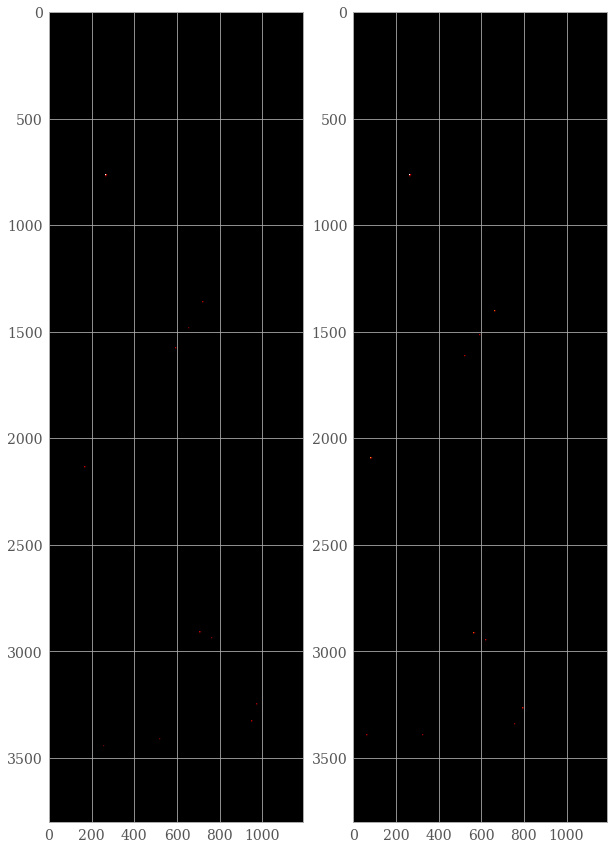

In [171]:
hdu_list = [maskingDataFake['maskedImage'],maskingDataRefFake['maskedImage']]
newhdu = hdu_list[0][0:,450:-54]

print(newhdu.shape)
alignedHDU = alignImages([newhdu,hdu_list[1]])
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(alignedHDU[0])
ax2.imshow(alignedHDU[1])
plt.show()

In [173]:
hduOg = [getImageData('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits',0),getImageData('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits',0)]
hduOg[0] = hduOg[0][0:,450:-54]

(3800, 1190)


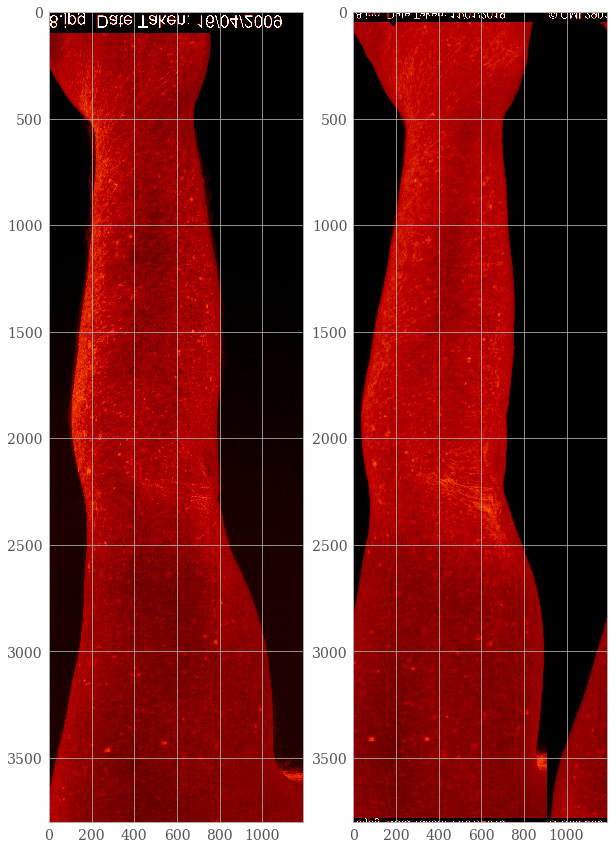

In [176]:
hdu_list = [maskingDataFake['maskedImage'],maskingDataRefFake['maskedImage']]
newhdu = hdu_list[0][0:,450:-54]

print(newhdu.shape)
alignedHDU = alignImagesAlt([newhdu,hdu_list[1]],hduOg)
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(alignedHDU[0])
ax2.imshow(alignedHDU[1])
plt.show()

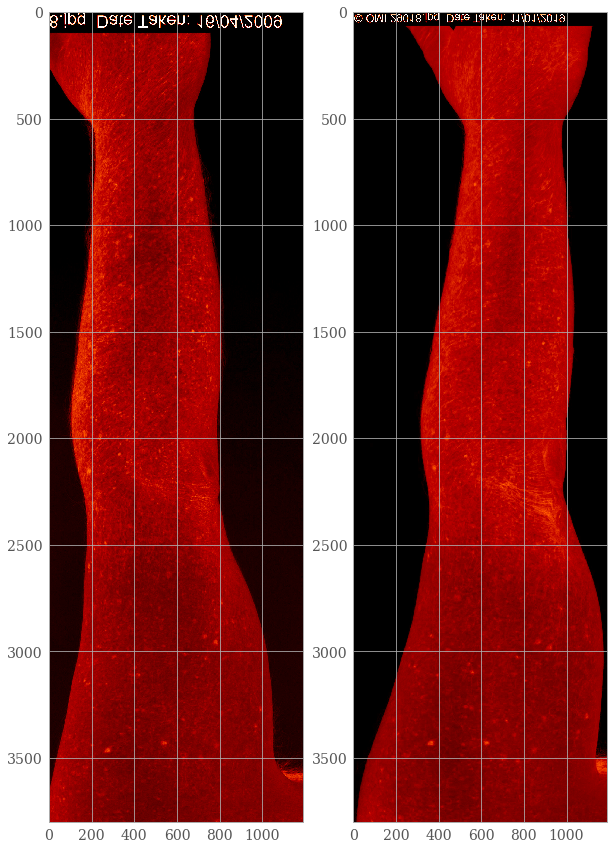

In [179]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(hduOg[0])
ax2.imshow(hduOg[1])
plt.show()

(3800, 1190)


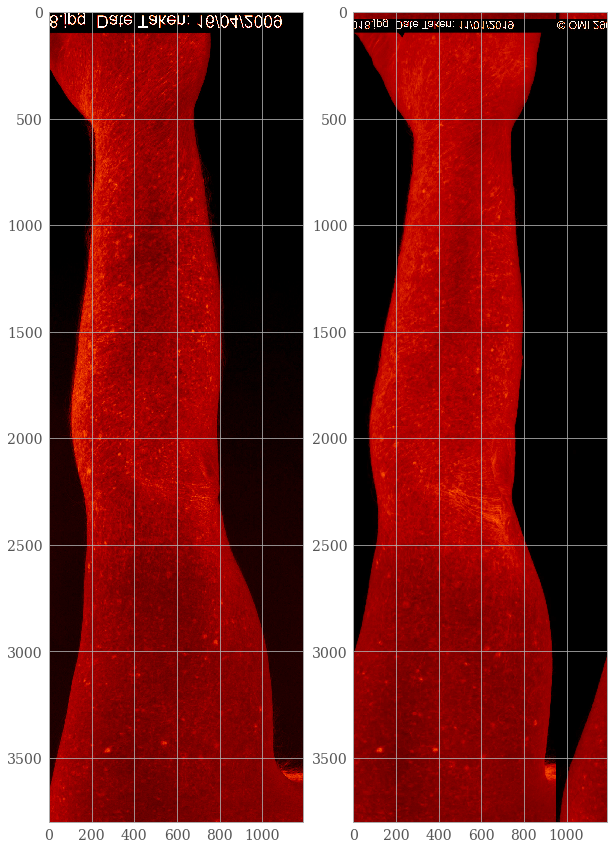

In [177]:
# hdu_list = [maskingDataFake['maskedImage'],maskingDataRefFake['maskedImage']]
# newhdu = hdu_list[0][0:,450:-54]

print(newhdu.shape)
alignedHDU2 = alignImages(alignedHDU)
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(alignedHDU2[0])
ax2.imshow(alignedHDU2[1])
plt.show()

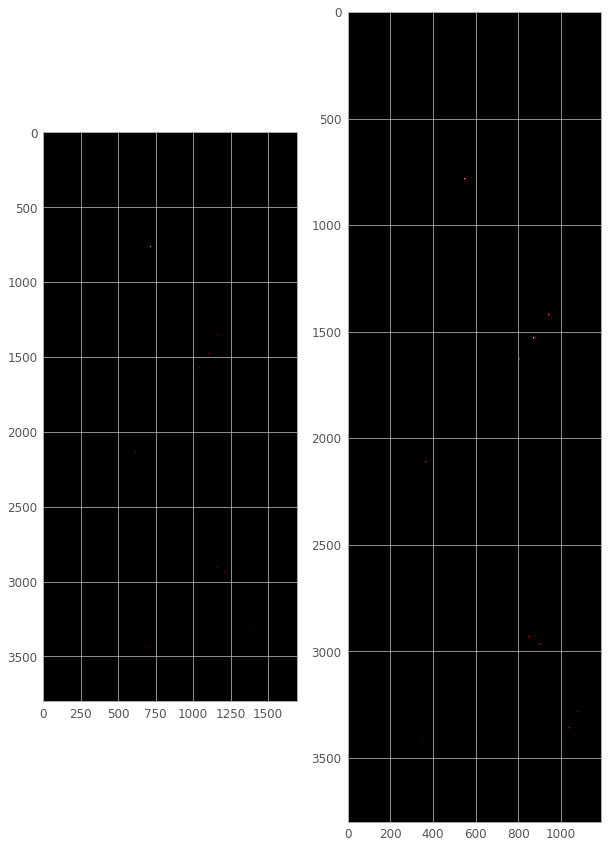

In [259]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(hdu_list[0])
ax2.imshow(hdu_list[1])
plt.show()

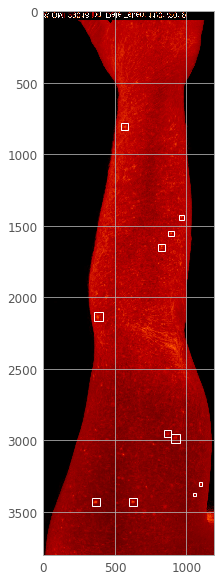

In [182]:
plotMolesOnly('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits','./29018blueMolePositions.txt')

(50, 50)
(50, 50)
(66, 66)
(42, 42)
(28, 28)
(32, 34)
(40, 40)
(32, 32)
(32, 34)
(20, 20)
(40, 40)


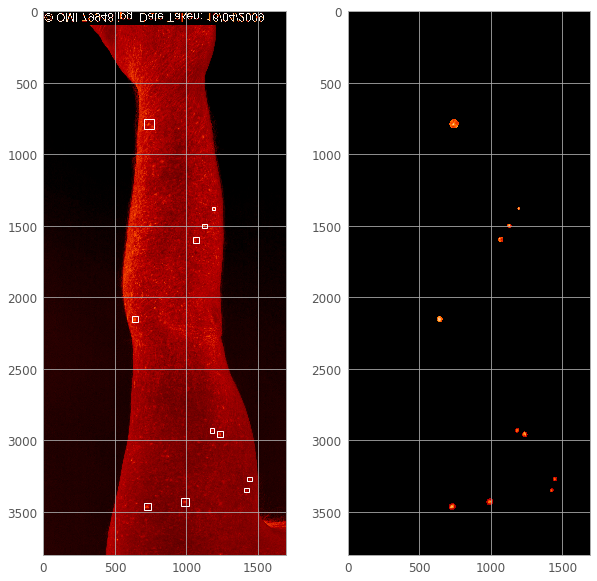

In [180]:
maskingData = plotMolesAndMask('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits','./79948blueMolePositions.txt')

(46, 46)
(60, 60)
(56, 56)
(56, 56)
(24, 24)
(22, 22)
(60, 60)
(46, 46)
(52, 50)
(38, 38)
(36, 36)


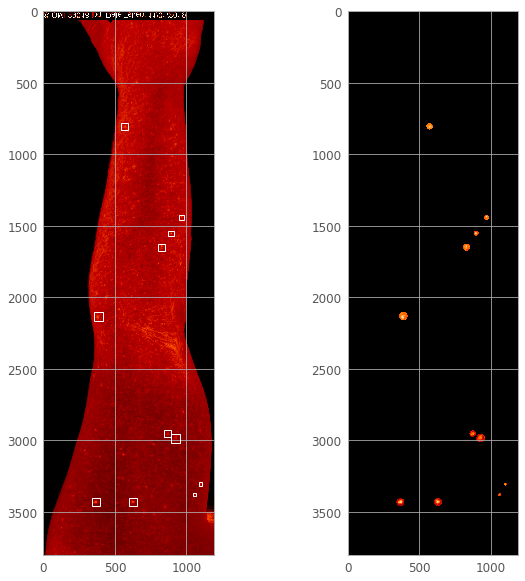

In [183]:
maskingDataRef = plotMolesAndMask('/home/mj1e16/moleGazer/Photos/F/29018Invertedblue.fits','./29018blueMolePositions.txt')

In [209]:
hdulist = [maskingData['maskedImage'],maskingDataRef['maskedImage']]

In [198]:
newhdu = hdulist[0][0:,450:-54]
print(newhdu.shape)

(3800, 1190)


In [219]:
for i,x in enumerate(hdulist):
    scipy.misc.imsave('outfile'+str(i)+'.jpg', x)

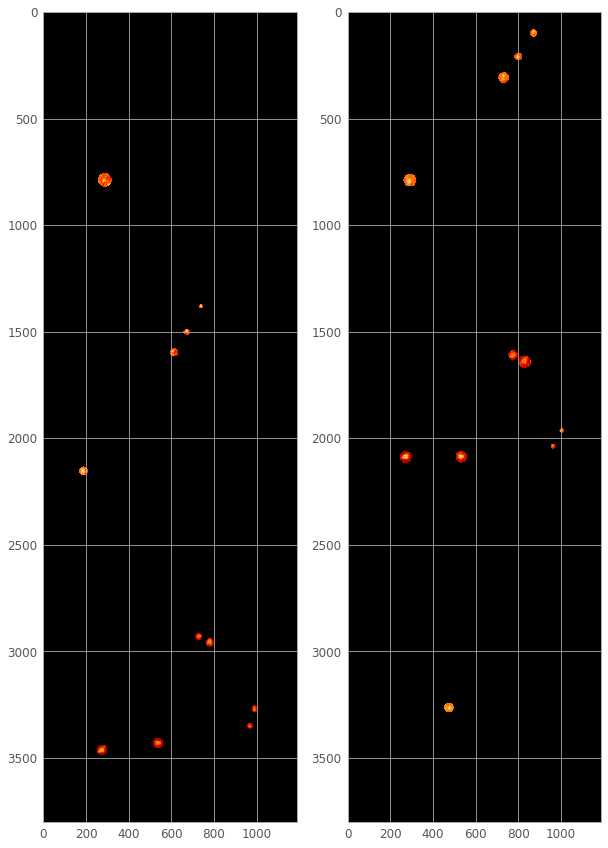

In [200]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(alignedImages[0])
ax2.imshow(alignedImages[1])
plt.show()

In [11]:
alignlocs = ds9File2Lists('./79948blueMolePositions.txt')
reflocs = ds9File2Lists('./29018blueMolePositions.txt')

In [14]:
imdata = getImageData('/home/mj1e16/moleGazer/Photos/F/79948Invertedblue.fits',0)

In [19]:
mask = []
for mole in range(len(alignlocs[0])):
    centre = PixCoord(alignlocs[0][mole],alignlocs[1][mole])
    reg = CirclePixelRegion(centre,alignlocs[2][mole])
    mask.append(reg.to_mask())


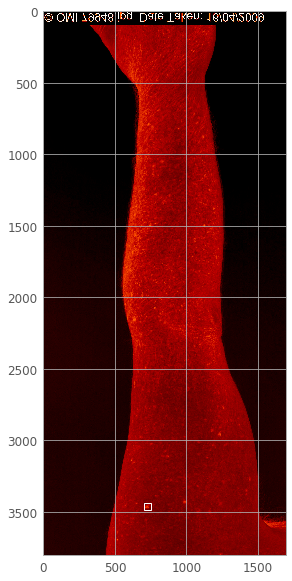

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(imdata)
ax.add_artist(mask[0].bbox.as_artist(facecolor='none', edgecolor='white'))
plt.show()

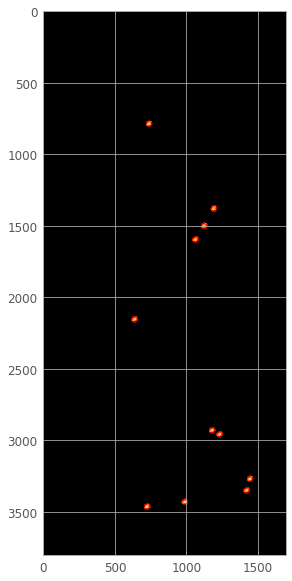

In [131]:
zeros = np.zeros(imdata.shape)
maskData = []
for m in mask:
    maskData.append(m.cutout(imdata)*m.data)
    
for x in range(len(maskData)):
    zeros[int(alignlocs[1][x])-25:int(alignlocs[1][x])+25,int(alignlocs[0][x])-25:int(alignlocs[0][x])+25] = data

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(zeros)

#newax = fig.add_axes(rect,anchor='NE')
#newax = fig.add_axes([0.8, 0.8, 0.2, 0.2], anchor='NE', zorder=-1)

#newax.imshow(data)
#ax.add_artist(mask[0].bbox.as_artist(facecolor='none', edgecolor='white'))
plt.show()

In [13]:
imageRefernce = '/home/mj1e16/moleGazer/Photos/F/29018.jpg'
imageAlign =  '/home/mj1e16/moleGazer/Photos/F/79948.jpg'

In [15]:
alignedHDU = alignImages(hdu_list)

Image size: 1190 x 3800
(4522000,)
/home/mj1e16/moleGazer/Photos/F/29018Inverted
66.90609213343083 89.0 54.582023222885155


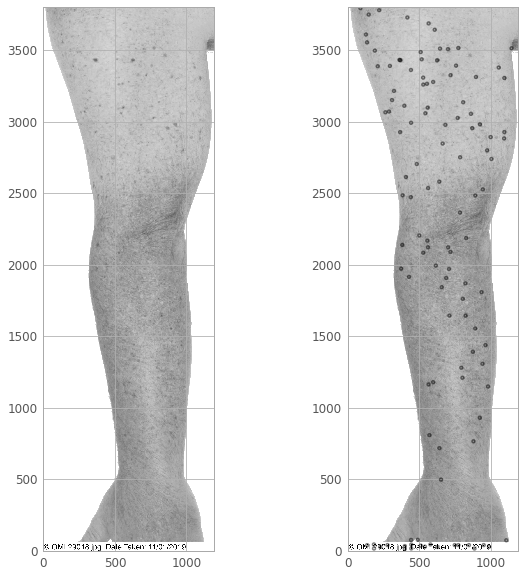

39.340150160965905 51.0 32.74172185653438


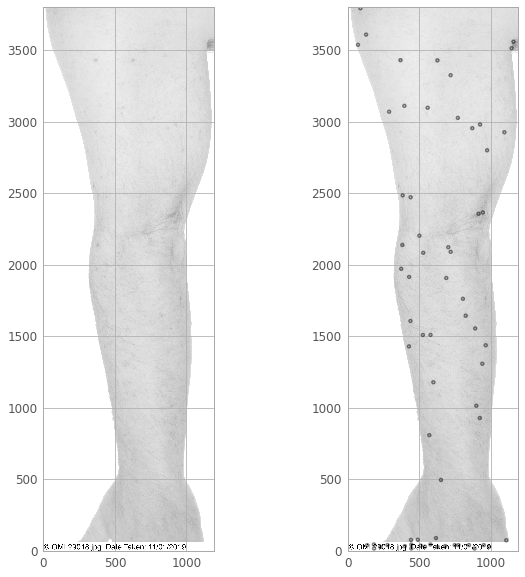

60.60381469095775 85.0 48.90740743315526


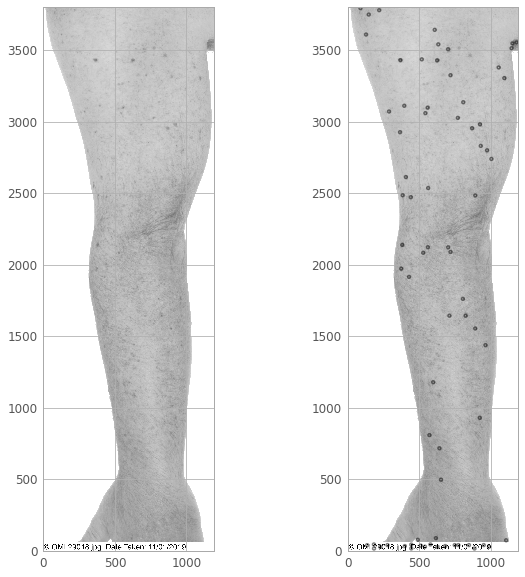

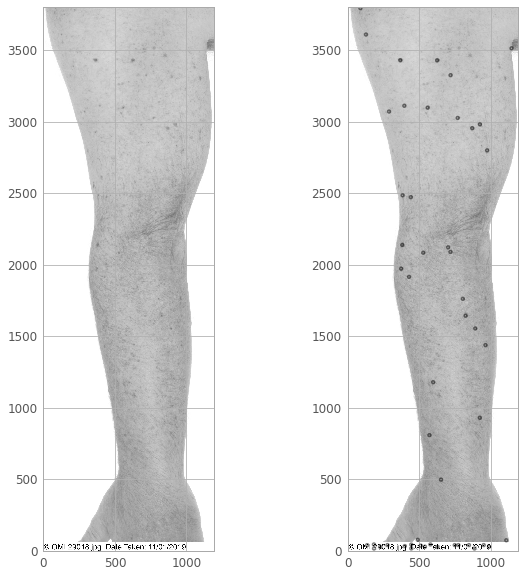

In [40]:
matchedObjects = findAndRefine(imageRefernce)

Image size: 1694 x 3800
(6437200,)
/home/mj1e16/moleGazer/Photos/F/79948Inverted
43.595306625182324 0.0 51.36032811380945


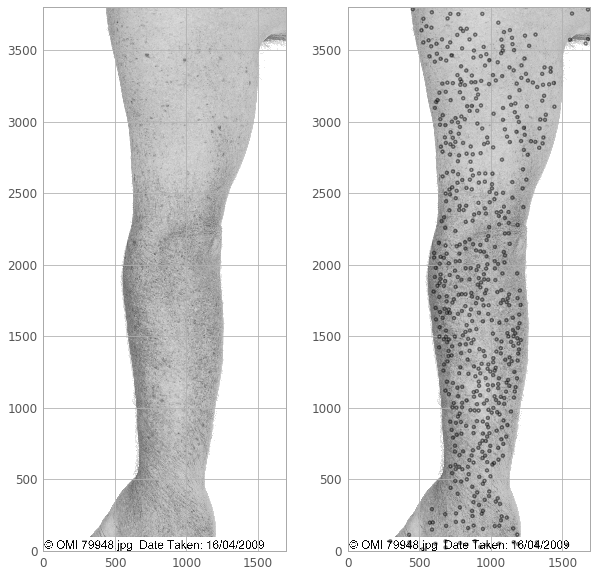

23.319864956995517 0.0 28.110202583683904


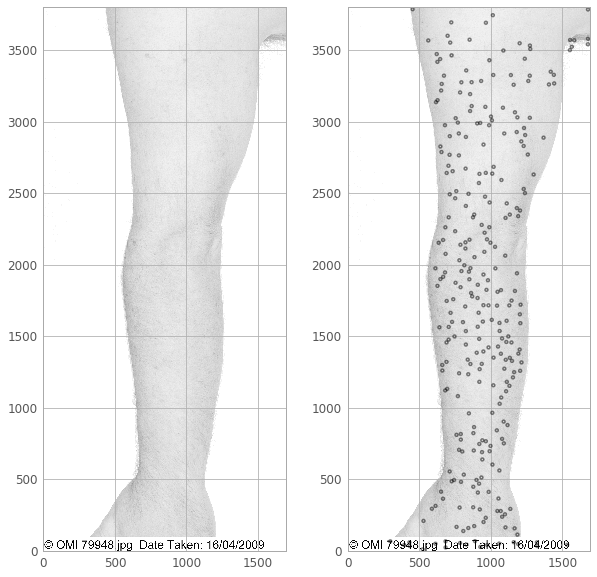

37.688935010539225 0.0 44.16477174977314


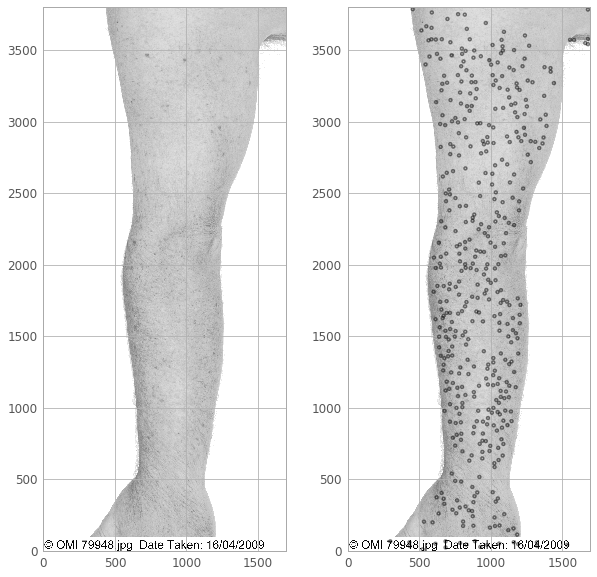

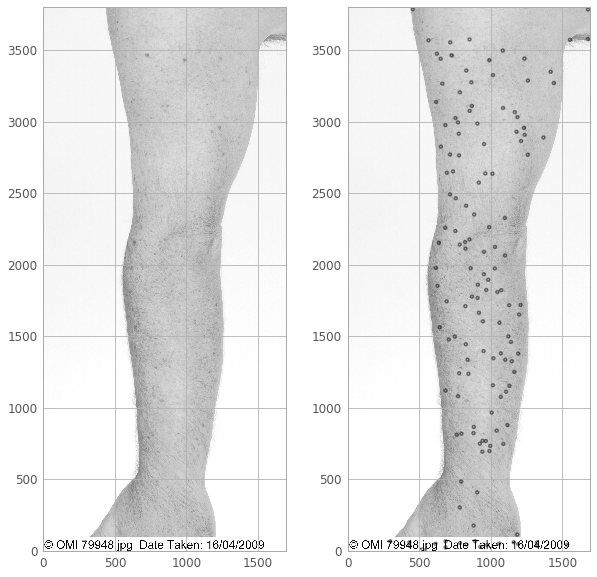

In [42]:
matchedObjects = findAndRefine(imageAlign,fwhm=30,thr=2)